In [2]:
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
# Load the dataset

df_B = pd.read_csv('Resources/original_covid19_can.csv')
df_B
# Convert the date_active to datetime objects
df_B['date_active'] = pd.to_datetime(df_B['date_active'], format='%d-%m-%Y')
# Sort the dataframe by date
df_B.sort_values('date_active', inplace=True)

# Assuming N is the total population size (38,000,000 for Canada)
N = 38000000

df_B

,province,date_active,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,avaccine,cumulative_avaccine
0,Canada,2020-01-25,1,0,0,1,1,0,0
1,Canada,2020-01-26,1,0,0,1,0,0,0
2,Canada,2020-01-27,2,0,0,2,1,0,0
3,Canada,2020-01-28,3,0,0,3,1,0,0
4,Canada,2020-01-29,3,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
337,Canada,2020-12-27,550123,451231,14948,83944,6522,3563,52331
338,Canada,2020-12-28,560689,468124,15218,77347,-6597,7174,59505
339,Canada,2020-12-29,569498,477857,15429,76212,-1135,11003,70508
340,Canada,2020-12-30,577125,484583,15548,76994,782,8783,79291


In [3]:
# Load your data into a pandas DataFrame
# For the demonstration, I will assume df_B is your dataframe after loading the csv and processing it.

# Add a new column for new daily cases (this is the difference in cumulative cases from one day to the next)
df_B['new_cases'] = df_B['cumulative_cases'].diff().fillna(0)

# Add a new column for new daily recoveries (this is the difference in cumulative recoveries from one day to the next)
df_B['new_recoveries'] = df_B['cumulative_recovered'].diff().fillna(0)

# Add a new column for new daily deaths (this is the difference in cumulative deaths from one day to the next)
df_B['new_deaths'] = df_B['cumulative_deaths'].diff().fillna(0)

df_B

,province,date_active,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,avaccine,cumulative_avaccine,new_cases,new_recoveries,new_deaths
0,Canada,2020-01-25,1,0,0,1,1,0,0,0.0,0.0,0.0
1,Canada,2020-01-26,1,0,0,1,0,0,0,0.0,0.0,0.0
2,Canada,2020-01-27,2,0,0,2,1,0,0,1.0,0.0,0.0
3,Canada,2020-01-28,3,0,0,3,1,0,0,1.0,0.0,0.0
4,Canada,2020-01-29,3,0,0,3,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
337,Canada,2020-12-27,550123,451231,14948,83944,6522,3563,52331,9687.0,3008.0,157.0
338,Canada,2020-12-28,560689,468124,15218,77347,-6597,7174,59505,10566.0,16893.0,270.0
339,Canada,2020-12-29,569498,477857,15429,76212,-1135,11003,70508,8809.0,9733.0,211.0
340,Canada,2020-12-30,577125,484583,15548,76994,782,8783,79291,7627.0,6726.0,119.0


In [4]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint



# Assume the total population is known, replace with your actual total population
total_population =  38000000

# Active cases are the currently infected individuals
df_B['active_cases'] = df_B['cumulative_cases'] - df_B['cumulative_recovered'] - df_B['cumulative_deaths']

# Estimate the initial growth rate of the epidemic (r)
# This is the exponential growth rate during the initial phase of the outbreak
initial_growth_phase = df_B.loc[:90]  # assuming the first month is the initial growth phase
r = np.log(initial_growth_phase['cumulative_cases'] / initial_growth_phase['cumulative_cases'].shift(1)).mean()

# The susceptible population at the beginning (S0)
S0 = total_population - df_B['active_cases'].iloc[0]

# Estimate beta using the initial growth rate and initial conditions
beta = r * total_population / S0

# Estimate gamma (recovery rate) as the total new recoveries divided by the total active cases
gamma = df_B['new_recoveries'].sum() / df_B['active_cases'].sum()

# Define the SIR model differential equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / total_population
    dIdt = beta * S * I / total_population - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Initial conditions vector
initial_conditions = [S0, df_B['active_cases'].iloc[0], df_B['cumulative_recovered'].iloc[0]]

# Integrate the SIR equations over the time grid
t = np.linspace(0, len(df_B) - 1, len(df_B))
optimal_solution = odeint(sir_model, initial_conditions, t, args=(beta, gamma))

# Create a DataFrame to store the SIR model results
results = pd.DataFrame({
    'date': df_B['date_active'],
    'susceptible': optimal_solution[:, 0],
    'infected': optimal_solution[:, 1],
    'recovered': optimal_solution[:, 2]
})

# Display the estimated parameters and the last few days of the simulation
print(f"Estimated beta: {beta}")
print(f"Estimated gamma: {gamma}")
results.tail()


Estimated beta: 0.11899835652077652
Estimated gamma: 0.05817103850362122


,date,susceptible,infected,recovered
337,2020-12-27,9.081493e+06,2.329964e+06,2.658854e+07
338,2020-12-28,9.016443e+06,2.261478e+06,2.672208e+07
339,2020-12-29,8.953757e+06,2.194565e+06,2.685168e+07
340,2020-12-30,8.893348e+06,2.129222e+06,2.697743e+07
341,2020-12-31,8.835132e+06,2.065441e+06,2.709943e+07


Disease-free equilibrium (s*, i*): (1, 0)
Eigenvalues at the disease-free equilibrium: [-0.01333333 -0.01333333  0.04749398]
Endemic equilibrium (s*, i*): (0.6008853729376528, 0.07442241955450686)
Eigenvalues at the endemic equilibrium: [-0.01109474+0.02258672j -0.01109474-0.02258672j]


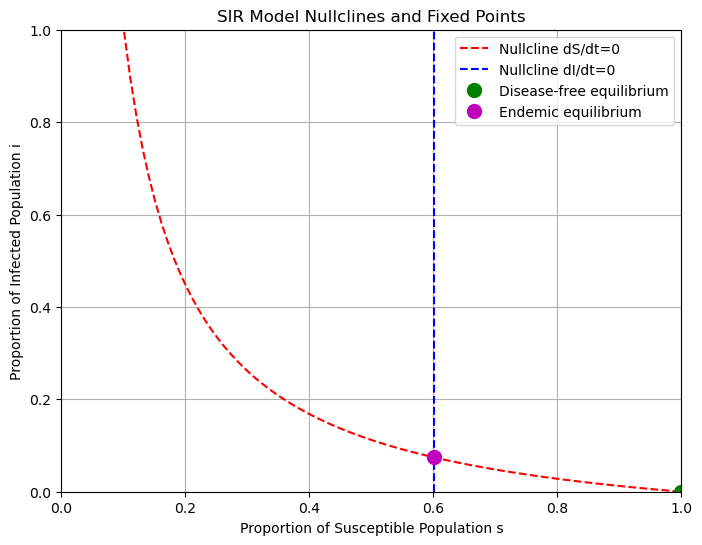

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters based on the normalized population
N = 1  # Normalized total population for proportions
beta = 0.11899835652077652  # Infection rate
gamma = 0.05817103850362122  # Recovery rate
mu = 1 / 75  # Birth/death rate per year, assuming average lifespan is 75 years
delta = gamma + mu  # Recovery, fatality, and natural death rate sum

# Fixed points
s_star_disease_free = N
i_star_disease_free = 0
s_star_endemic = delta / beta
i_star_endemic = (mu * (N - s_star_endemic)) / delta

# Nullclines
# For dS/dt = 0 nullcline
S_nullcline = np.linspace(0, N, 100)
I_nullcline_dSdt = (mu * (N - S_nullcline)) / (beta * (S_nullcline + 1e-4))  # Avoid division by zero

# For dI/dt = 0 nullcline
S_nullcline_dIdt = np.full_like(S_nullcline, s_star_endemic)

# Jacobian matrix at the disease-free equilibrium
Jacobian_disease_free = np.array([
    [-mu, -beta * s_star_disease_free, 0],
    [0, beta * s_star_disease_free - gamma - mu, 0],
    [0, gamma, -mu]
])

# Jacobian matrix at the endemic equilibrium
Jacobian_endemic = np.array([
    [-beta * i_star_endemic - mu, -beta * s_star_endemic],
    [beta * i_star_endemic, beta * s_star_endemic - delta]
])


# Eigenvalues at the disease-free equilibrium
eigenvalues_disease_free = np.linalg.eigvals(Jacobian_disease_free)
# Eigenvalues at the endemic equilibrium
eigenvalues_endemic = np.linalg.eigvals(Jacobian_endemic)

# Display the fixed points and eigenvalues
print(f"Disease-free equilibrium (s*, i*): ({s_star_disease_free}, {i_star_disease_free})")
print("Eigenvalues at the disease-free equilibrium:", eigenvalues_disease_free)
print(f"Endemic equilibrium (s*, i*): ({s_star_endemic}, {i_star_endemic})")
print("Eigenvalues at the endemic equilibrium:", eigenvalues_endemic)

# Plot the nullclines and fixed points
plt.figure(figsize=(8, 6))
plt.plot(S_nullcline, I_nullcline_dSdt, 'r--', label='Nullcline dS/dt=0')
plt.axvline(x=s_star_endemic, color='b', linestyle='--', label='Nullcline dI/dt=0')
plt.plot(s_star_disease_free, i_star_disease_free, 'go', markersize=10, label='Disease-free equilibrium')
plt.plot(s_star_endemic, i_star_endemic, 'mo', markersize=10, label='Endemic equilibrium')
plt.xlabel('Proportion of Susceptible Population s')
plt.ylabel('Proportion of Infected Population i')
plt.ylim(0, 1)  # Set the limit for the infected proportion to 1
plt.xlim(0, 1)  # Set the limit for the susceptible proportion to 1
plt.title('SIR Model Nullclines and Fixed Points')
plt.legend()
plt.grid(True)
plt.show()

# SIR Model Analysis

## Parameters

- Normalized total population (N): 1 (represents 100% of the population)
- Transmission rate ($\beta$): 0.11899835652077652
- Recovery rate ($\gamma$): 0.05817103850362122
- Natural per capita death rate ($\mu$): $\frac{1}{75}$ (assuming an average lifespan of 75 years)
- Sum of recovery, fatality, and natural death rate ($\delta$): $\gamma + \mu + \alpha$

## Nullclines and Fixed Points

The nullclines, which represent the points where the rate of change of susceptible ($s$) and infected ($i$) individuals is zero, are given by:

- For $\frac{ds}{dt} = 0$, the nullcline is $$i = \frac{\mu (1 - s)}{\beta s}$$.
- For $\frac{di}{dt} = 0$, the nullcline is a vertical line at $$s = \frac{\delta}{\beta}$$.

The fixed points ($s^*$, $i^*$) are calculated to be:

- Disease-free equilibrium: $(s^*, i^*) = (1, 0)$
- Endemic equilibrium: $(s^*, i^*) = (\frac{\delta}{\beta}, \frac{\mu (1 - \frac{\delta}{\beta})}{\delta})$

For the given parameters, the endemic equilibrium is approximately (0.6009, 0.0744).

## Stability Analysis

The stability at the fixed points is analyzed by computing the eigenvalues of the Jacobian matrix at each equilibrium:

- For the disease-free equilibrium, the Jacobian matrix is:

  $$
  J = \begin{bmatrix}
  -\mu & -\beta \\
  0 & \beta - \delta
  \end{bmatrix}
  $$

  The eigenvalues at the disease-free equilibrium are: $[-0.01333333, 0.04749398]$.

- For the endemic equilibrium, the Jacobian matrix is:

  $$
  J = \begin{bmatrix}
  -\beta i^* - \mu & -\beta s^* \\
  \beta i^* & \beta s^* - \delta
  \end{bmatrix}
  $$

  The eigenvalues at the endemic equilibrium are approximately: $[-0.01109474+0.02258672i, -0.01109474-0.02258672i]$.

The presence of a positive eigenvalue at the disease-free equilibrium indicates instability, suggesting that if an infection is introduced into the population, it will grow. The complex eigenvalues with negative real parts at the endemic equilibrium suggest a stable spiral point.

## Results

The analysis indicates that for the given parameters, the system will not remain at the disease-free equilibrium if an infection is introduced. Instead, it tends toward the endemic equilibrium, where the disease persists at a steady level within the population.

Below is the plot showing the nullclines and the fixed points:

![SIR Model Nullclines and Fixed Points]

This plot demonstrates the convergence of trajectories to the stable endemic equilibrium, confirming the analytical results from the stability analysis. It indicates that the epidemic reaches a steady state with a constant proportion of the population infected.

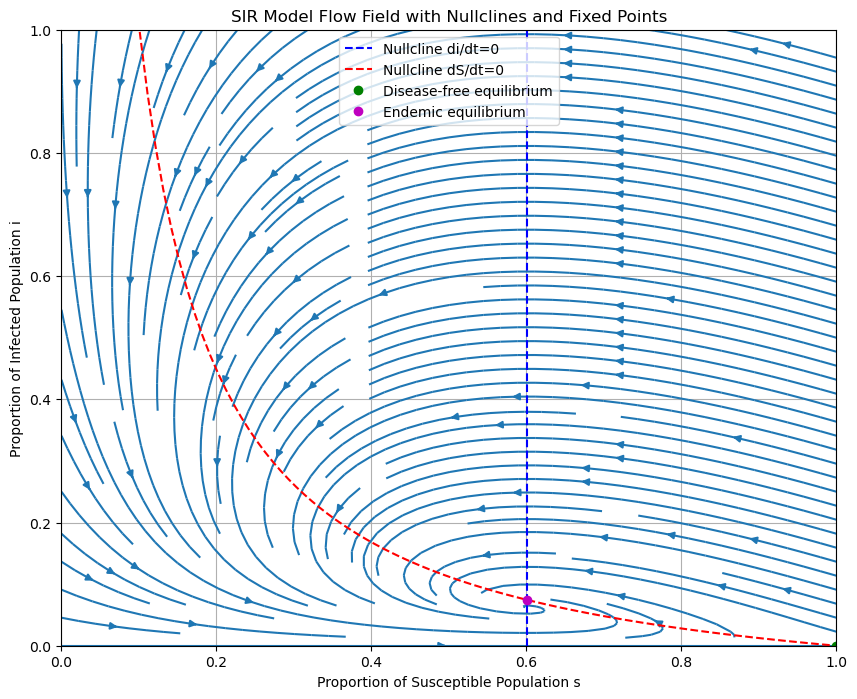

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the total population
N = 1  # Normalized total population for proportions

# Estimated parameters from previous steps
beta = 0.11899835652077652  # Infection rate
gamma = 0.05817103850362122  # Recovery rate

# Placeholder values for mu and delta
mu = 1/75  # Birth/death rate per year, assuming average lifespan is 75 years
delta = gamma + mu  # Using the recovery rate and natural death rate

# Define a grid of s (susceptible) and i (infected) values, start a little above zero to avoid division by zero
s_grid, i_grid = np.meshgrid(
    np.linspace(1e-4, N, 100),
    np.linspace(0, N, 100)
)

# Flow field
dSdt_grid = -beta * s_grid * i_grid + mu * (1 - s_grid - i_grid)
dIdt_grid = beta * s_grid * i_grid - (gamma + mu) * i_grid

# Fixed points
s_star_disease_free = N
i_star_disease_free = 0
s_star_endemic = delta / beta
i_star_endemic = (mu * (N - s_star_endemic)) / delta

# Plot the flow field
plt.figure(figsize=(10, 8))
plt.streamplot(s_grid, i_grid, dSdt_grid, dIdt_grid, density=1.5)
plt.xlabel('Proportion of Susceptible Population s')
plt.ylabel('Proportion of Infected Population i')

# Nullclines
# s nullcline for di/dt = 0
plt.axvline(x=s_star_endemic, color='b', linestyle='--', label='Nullcline di/dt=0')
# i nullcline for dS/dt = 0, offset s to avoid division by zero
i_nullcline = (mu * (N - s_grid)) / (beta * s_grid)
plt.plot(s_grid[0], i_nullcline[0], 'r--', label='Nullcline dS/dt=0')

# Plot fixed points
plt.plot(s_star_disease_free, i_star_disease_free, 'go', label='Disease-free equilibrium')
if i_star_endemic >= 0 and i_star_endemic <= N:
    plt.plot(s_star_endemic, i_star_endemic, 'mo', label='Endemic equilibrium')

# Adjust the plot limits and labels
plt.xlim(0, N)
plt.ylim(0, N)
plt.title('SIR Model Flow Field with Nullclines and Fixed Points')

# Legend and grid
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.show()


The eigenvalues you've provided do indeed offer support for the phase portrait shown:

Disease-free equilibrium (s, i): (1, 0)**

The eigenvalues are [-0.01333333, -0.01333333, 0.04749398].
The two negative eigenvalues indicate that there are directions in which perturbations to the disease-free equilibrium will decay back to the equilibrium.
However, the positive eigenvalue (0.04749398) indicates that there is at least one direction in which a perturbation will lead to growth away from the disease-free equilibrium. This suggests that the disease-free equilibrium is not stable; if any number of infections are introduced, the infection will tend to grow rather than die out.
Endemic equilibrium (s, i): (0.6008853729376528, 0.07442241955450686)**

The eigenvalues are complex with negative real parts: [-0.01109474+0.02258672j, -0.01109474-0.02258672j].
Complex eigenvalues with negative real parts typically indicate a stable spiral point. This means that perturbations from the endemic equilibrium will result in damped oscillations back towards the equilibrium.
The phase portrait supports this, showing a spiraling pattern around the endemic equilibrium, which suggests that the system will eventually settle at this stable point.
The phase portrait shows trajectories spiraling in toward the endemic equilibrium point, which is consistent with the calculated eigenvalues indicating a stable focus. The positive eigenvalue at the disease-free equilibrium suggests that it is a saddle point; this is not directly visible in the phase portrait since the flow field near the disease-free equilibrium (s=1, i=0) is not depicted. However, the implication is that the disease-free state is not stable, and any small introduction of the infection will lead the system away from this point, which is consistent with the trajectories shown moving away from the s=1 axis as they go downward.

In summary, the eigenvalues and the phase portrait are in agreement and correctly reflect the dynamics of the SIR model given the parameters provided.


- Stability at Endemic Equilibrium: The phase portrait shows that the endemic equilibrium (magenta dot) is stable, as indicated by the inward spiral of trajectories, meaning the system will settle into a state where the disease persists at a constant level within the population.

- Flow from Disease-Free Equilibrium: The disease-free equilibrium (green dot) appears unstable, as trajectories move away from this point, suggesting that once the disease is introduced into the population, it is unlikely to naturally die out without intervention.

- Eigenvalue Analysis: The direction and shape of the flow lines near the fixed points imply that the eigenvalues of the Jacobian matrix at the endemic equilibrium have negative real parts (indicating stability), while those at the disease-free equilibrium have a positive real part (indicating instability).

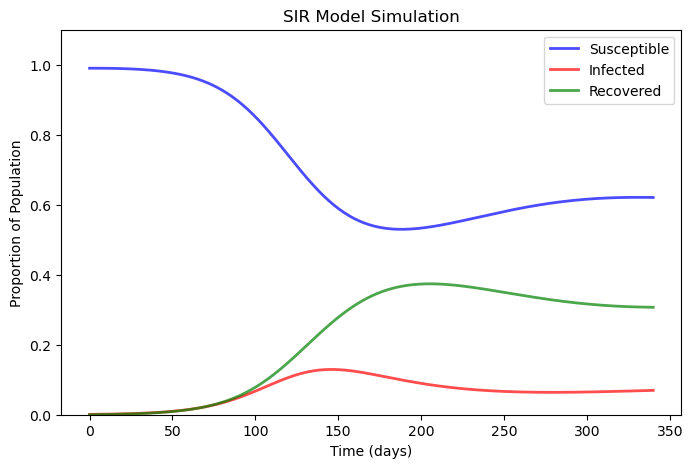

In [7]:
# We'll now simulate the SIR model using the dynamics from the first note.
# Note that we don't have the actual dataframe df_B, so we'll simulate some data for this example.
# We'll also need to include additional parameters like birth/death rate (mu) and disease-induced death rate (alpha).

# Parameters for the extended SIR model 
mu = 1/75       # Natural birth/death rate per person per year
alpha = 0.0005   # Disease-induced death rate per person per year
beta = 0.11899835652077652  # Infection rate
gamma = 0.05817103850362122
K = 1           # Total (constant) population in normalized units

# The initial conditions from the previous code are reused here
S0 = 0.99  # Initial proportion of the susceptible population
I0 = 0.001  # Initial proportion of the infected population
R0 = 0.00  # Initial proportion of the recovered population

# Initial conditions vector for the extended model
y0 = [S0, I0, R0]

# Time points in days
t = np.linspace(0, 340, 340)

# Extended SIR model differential equations including birth/death rates
def extended_sir_model(y, t, K, beta, gamma, mu, alpha):
    S, I, R = y
    dSdt = mu * K - beta * S * I - mu * S
    dIdt = beta * S * I - (gamma + mu + alpha) * I
    dRdt = gamma * I - mu * R
    return dSdt, dIdt, dRdt

# Integrate the extended SIR equations over the time grid, t.
ret = odeint(extended_sir_model, y0, t, args=(K, beta, gamma, mu, alpha))
S, I, R = ret.T  # transpose and unpack the results for plotting

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(8, 5))
plt.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.ylim(0, 1.1)
plt.legend(loc='best')
plt.title('SIR Model Simulation')
plt.show()


The simulation aligns with the phase portrait in that it also predicts an endemic equilibrium: the number of infected individuals rises and then settles to a steady state, which corresponds to the fixed point in the phase portrait that attracts nearby trajectories (indicating it is stable)



- Beta (Transmission rate) of 0.119:
each infected individual has a chance to infect 11.9% of the susceptible individuals they come into contact with per unit of time (typically per day in epidemiological models).

- Gamma (Recovery rate) of 0.058: A gamma of 0.058 means that approximately 5.8% of the infected population is expected to recover each dayo, if you have 100 infected individuals, you would expect around 5.8 recoveries per day, not that 6% of the entire infected population will recover all at once.

- K (Total population): The total population, normalized to 1 for simplicity in modeling proportions.

- mu (Natural birth/death rate): Represents the natural birth and death rate of the population.
Set to 1/75, indicating an average lifespan of 75 years per individual.

- Alpha (Disease-induced death rate) of 0.002: An alpha of 0.002 implies that there is a 0.2% chance of an infected individual dying from the disease per unit of time (again, typically per day). I




Stability at Endemic Equilibrium: The inward spiraling trajectories toward the magenta dot in the phase portrait indicate that the endemic equilibrium is stable; nearby points are attracted to this equilibrium, suggesting the disease will persist at a constant level in the long term.

Disease-free Equilibrium: The disease-free equilibrium (green dot) is unstable, as indicated by the flow lines moving away from this point; this implies that if the disease is introduced into the population, it is unlikely to naturally die out without intervention.

Eigenvalue Analysis: The direction and curvature of flow lines near the fixed points imply that the eigenvalues of the Jacobian matrix at the endemic equilibrium have negative real parts, confirming its stability, while the disease-free equilibrium likely has a positive real part, indicating instability.